# Portfolio Management 


## Optimierungsproblem
## Mögliche Ziele: erwartete Rendite maximieren oder Risiko reduzieren

Verwendete Methoden: 
- Autoencoder
- Riskoaufteilung mit hierarchischem Clustering
- Prognosebasiertes Portfolio
    - Exponentielles Glätten 
    - GARCH-Modell


Benchmark für den Vergleich der verwendenten Methoden:
- Gleichgewichtetes Portfolio dh. jede Aktie besitzt den gleichen Anteil am Gesamtportfolio


#### Grundlagen

- Portfoliorendite: $R_{PF} = w^{t} r $  , wobei $w $ Vektor mit den einzelnen Gewichten der Aktien und $ \sum_{i}^{n} w_i = 1  $
- Portfoliovarianz: $V_{PF} = w^{t} \Sigma w $ , wobei $\Sigma $ die Varianzkovarianzmatrix ist 
- Sharpe-Ratio: $SR_{PF} = \frac{R_{PF}-R_{riskolos}}{\sqrt{V_{PF}}}$ , wobei $R_{riskolos} =0 $


In [1]:
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os

import random
from collections import deque
import matplotlib.pylab as plt



Using TensorFlow backend.


 Laden der Aktiendaten



#### Folgende Aktien im Zeitraum vom 02.01.2018 bis 31.02.2020 betrachtet:

- SAP
- Siemens
- Bayer
- BASF
- Alianz
- Daimler
- Deutsche Telekom
- Adidas
- BMW 
- Volkswagen


Text(0, 0.5, 'Aktienpreis in Euro')

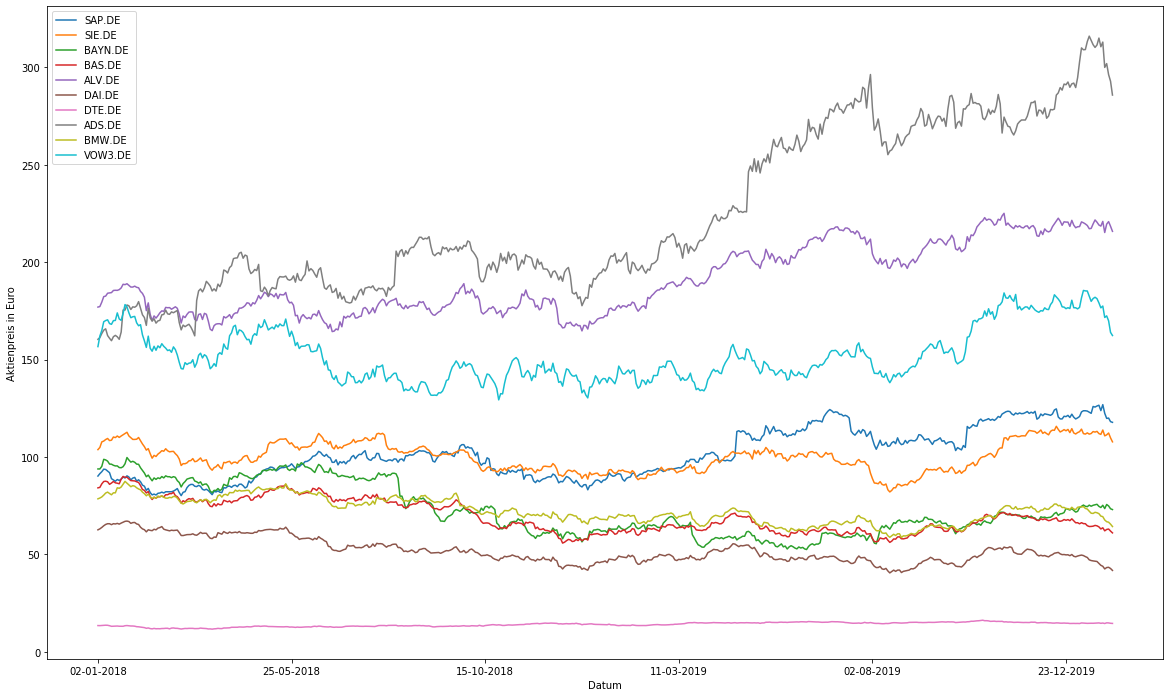

In [2]:
from environment import *
env = Environment()

data = env.load_data()
data.plot(figsize=(20,12))
plt.ylabel('Aktienpreis in Euro')

In [3]:
# Grundlegende Vereinbarungen
N_ASSETS = 10 # Anzahl der Aktien 
WINDOW_FIT = 125 # Trainingszeitraum in Tagen, entspricht ~ 6 Monaten
WINDOW_HOLD = 125 # Haltezeitraum in Tagen, entspricht ~ 6 Monaten 
env = Environment() # Import der Klasse Environment zum der Einlesen der Daten, sowie Bestimmung der Aktien-, Portfoliorendite etc.



# Autoencoder 


<div>
<img src="Autoencoder_Netz.png" width="350"/>
</div>


- Ziel der Autoencoder: Dimensionsreduzierung der ursprünglichen Daten
- $f:X \rightarrow F $ Encoderfunktion , $ f(x_i) = w_1 x_{i} +b_1$ falls linear, hier $f(x_i) = max(0,x_i)$
- $g:F \rightarrow X $ Decoderfunktion , $ g(x_i) = w_2 x_{i} +b_2$
- $ | x_i - ( g \circ f ) (x_i) | \rightarrow min \Leftrightarrow | x_i - w_2( max(0,x_i))+b_2 | \rightarrow min $ 
- Mittels Kleinste-Quadrate- Methode:  $\quad$
$ \sum (x_i - w_2( w_1 x_{i} +b_1 )+b_2)^2  \rightarrow min $ für die Parameter $w_1, w_2, b_1, b_2 $
- "Lernen" des Netzes mit Backpropagnition Algorithmus 





In [4]:
from agent import AutoencoderAgent # Laden der verwendeten Functionen aus der Klasse AutoencoderAgent

In [5]:
agent_ae = AutoencoderAgent(N_ASSETS, allow_short=True, encoding_dim = 5) # Dimensionsreduzierung auf 5

In [6]:
actions_equal, actions_ae = [], []
result_equal, result_ae = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD): #Start , Stop, Schritt 
    
    # Trainingszeitraum
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False, is_raw_time_series=True) # Daten für Trainingszeitraum 
    action_equal = np.ones(N_ASSETS) / N_ASSETS  # Anteile  der gleichgewichteten Aktien für die Benchmark
    action_ae = agent_ae.act(state)  # Gewichte der Aktien mittels Autoencoder
    
    
    # Realisierung der Rendite der Methode 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False) #Renditen Haltezeitraums 
    r = np.dot(state_action, action_equal) # Portfoliorendite gleichgewichtetes Portfolio
    result_equal.append(r.tolist())
    actions_equal.append(action_equal) # Aufbau Liste Renditen
    
    r = np.dot(state_action, action_ae) # Portfoliorendite Autoencoder Portfolio
    result_ae.append(r.tolist())
    actions_ae.append(action_ae)

In [7]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_ae_vis = [item for sublist in result_ae for item in sublist]

# Evaluation

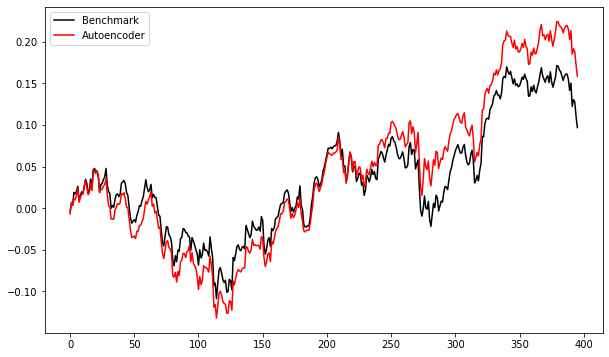

In [8]:
# Renditeverlauf des Gesamtportfolios

plt.figure(figsize=(10,6))
plt.plot(np.array(result_equal_vis).cumsum(),label='Benchmark', color = 'black')  
plt.plot(np.array(result_ae_vis).cumsum(),label='Autoencoder', color = 'red') 
plt.legend()
plt.show()

In [9]:
print('Methode' ,'Rendite','Volatilität','Sharpe-Ratio','alpha', 'beta' )
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('AUTOENCODER', print_stats(result_ae_vis, result_equal_vis))


Methode Rendite Volatilität Sharpe-Ratio alpha beta
EQUAL [0.0002, 0.01, 0.4046, -0.0, 1.0]
AUTOENCODER [0.0004, 0.0101, 0.6562, 0.0002, 0.9699]


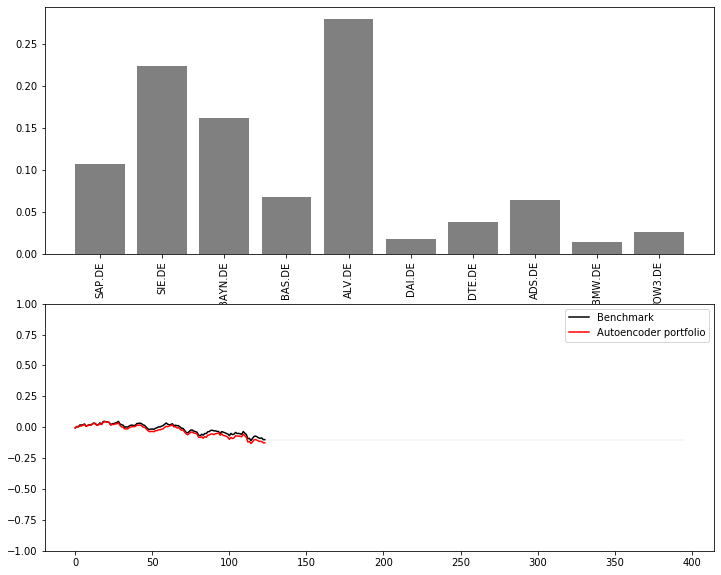

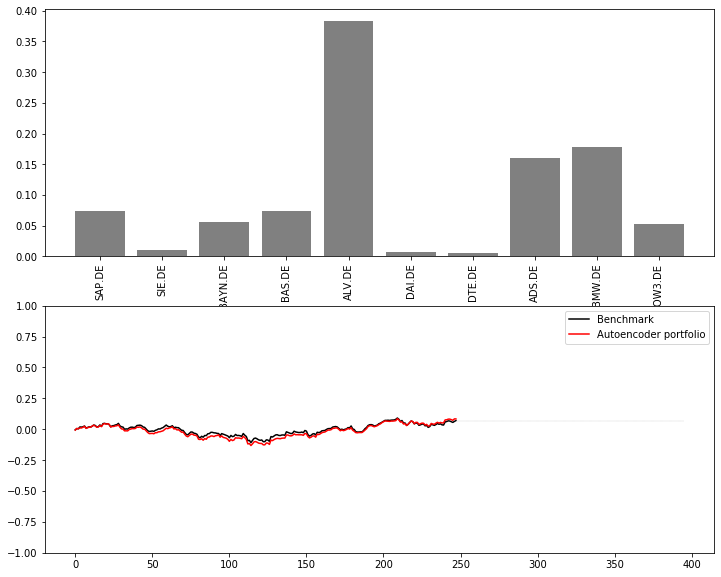

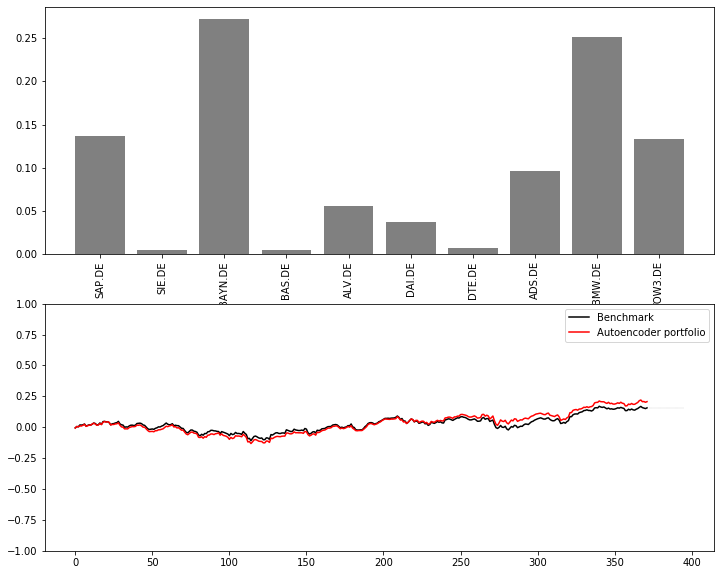

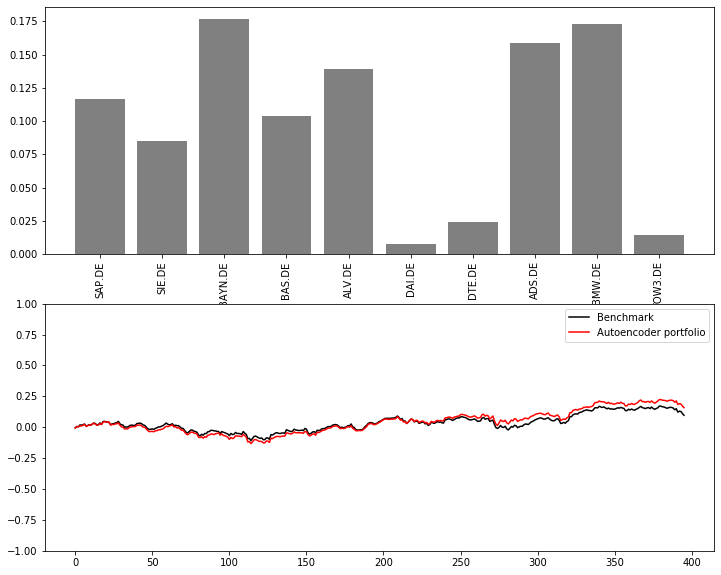

In [10]:
plot_results(result_equal, 
             result_ae, 
             actions_ae, 
             N_ASSETS,
             state.columns, 
             'Autoencoder portfolio', './images/ae/', 'series')


# Riskoaufteilung mit hierarchischem Clustering


- Methode verwendet die Allokation von Risiko
- Kovarianzmatrix kann als vollständiger Graph gesehen werden
- Zunächst keine hierarchische Struktur in der Kovarianzmatrix vorhanden
- Clusterbildung anhand der Kovarianzmatrix
- Risiko kann anhand des Clusters rekursiv umverteilt werden


<div>
<img src="HRP_Abbildung.png" width="500"/>
</div>



### Schritte des Algorithmus zur Erzeugung der hierarchischen Struktur:
1. Cluster erstellen  
1. Quasi Diagonalisierung
1. Rekursive Bisektion

wobei die Schritte 1-3 auch jeweils einzelne Algorithmen angewendet werden

In [11]:
from agent import HRPAgent
agent_hrp = HRPAgent(N_ASSETS, allow_short=True)

In [12]:
actions_equal, actions_hrp = [], []
result_equal, result_hrp = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    # Trainingszeitraum
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False)# Daten für Trainingszeitraum 
    action_equal = np.ones(N_ASSETS) / N_ASSETS # Benchmark  der gleichgewichteten Aktien
    action_hrp = agent_hrp.act(state) # Gewi3chte der Aktien mittels Autoencoder

    # Realisierung der Rendite der Methode 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False) # Renditen Haltezeitraums 
    
    r = np.dot(state_action, action_equal) # Portfoliorendite gleichgewichtetes Portfolio
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_hrp) # Portfoliorendite hierarchisches Clustering 
    result_hrp.append(r.tolist())
    actions_hrp.append(action_hrp)

In [13]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_hrp_vis = [item for sublist in result_hrp for item in sublist]

# Evaluation

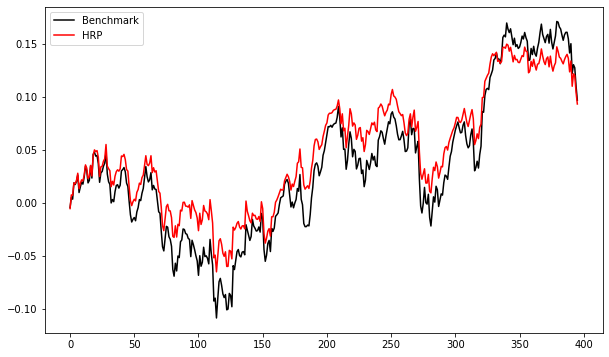

In [14]:
# Renditeverlauf des Gesamtportfolios

plt.figure(figsize=(10,6))
plt.plot(np.array(result_equal_vis).cumsum(),label='Benchmark', color = 'black')  
plt.plot(np.array(result_hrp_vis).cumsum(),label='HRP', color = 'red') 
plt.legend()
plt.show()

In [15]:
print('Portfolio' ,'Rendite','Volatilität','Sharpe-Ratio','alpha', 'beta' )
print('EQUAL HRP', print_stats(result_equal_vis, result_equal_vis))
print('HRP', print_stats(result_hrp_vis, result_equal_vis))

Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
EQUAL HRP [0.0002, 0.01, 0.4046, -0.0, 1.0]
HRP [0.0002, 0.0085, 0.4618, 0.0, 0.8266]


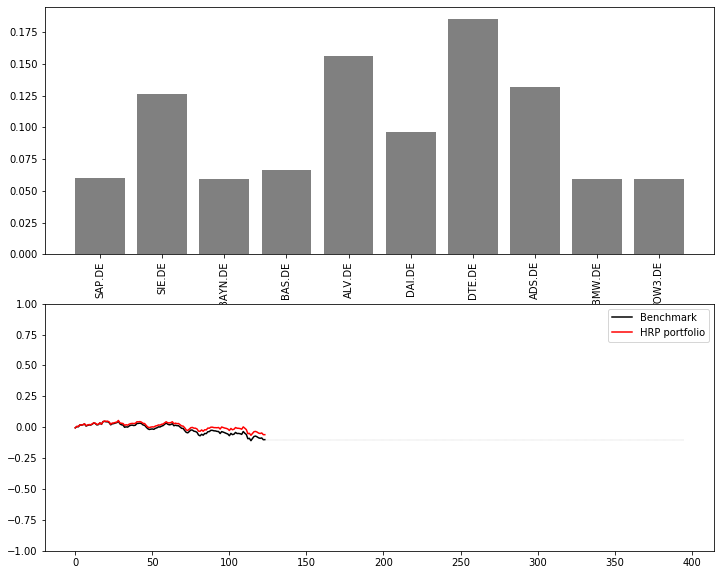

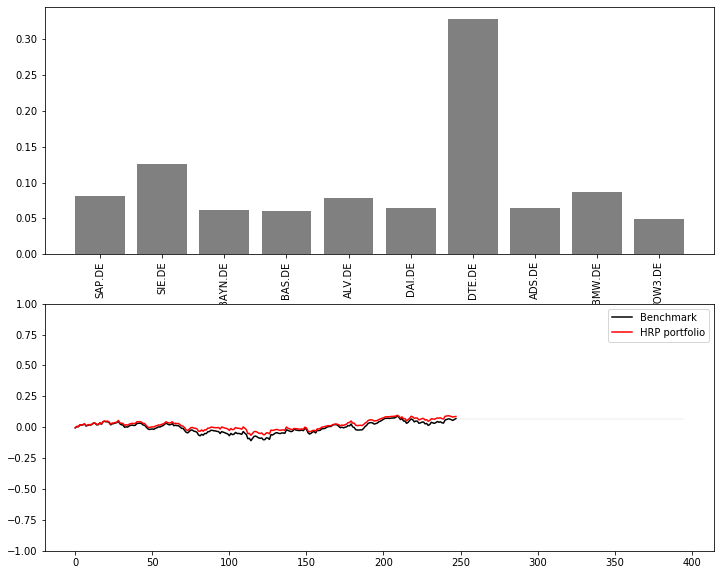

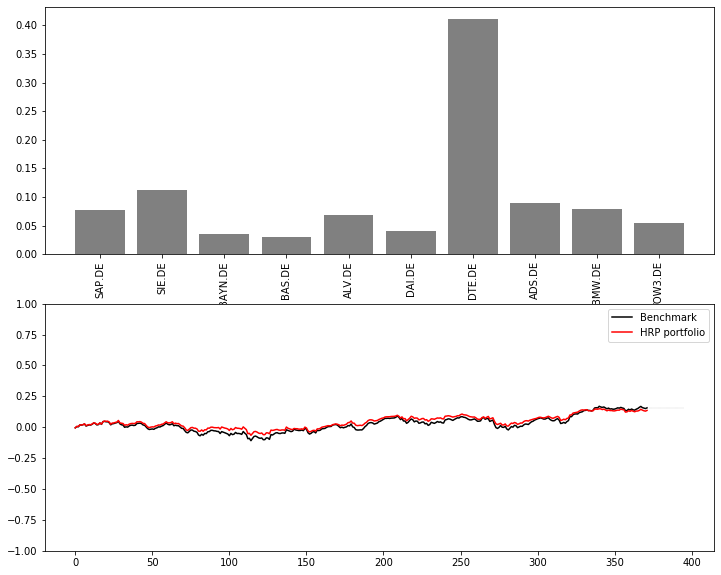

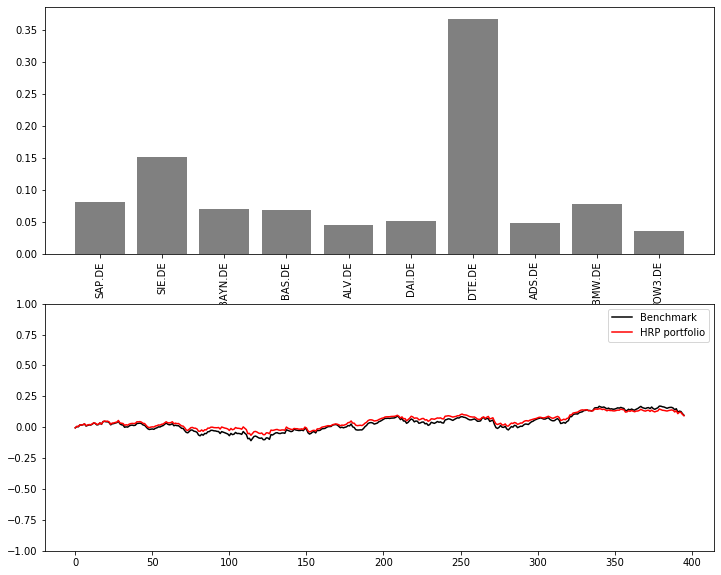

In [32]:
plot_results(result_equal, 
             result_hrp, 
             actions_hrp, 
             N_ASSETS,
             state.columns, 
             'HRP portfolio', './images/hrp/', 'series')

# Prognosebasiertes Portfolio 



##### Idee:
Wenn ein Modell zur Prognose der zukünftigen Aktienpreise exisitiert, können anhand der prognostizierten Preise entsprechende Gewichte verteilt werden um die Rendite zu erhöhen oder das Risiko zu minimieren

### Exponentielles Glätten
- $\hat{R_{t}} = \alpha \cdot R_{{t}}+(1-\alpha )\cdot \hat{R_{{t-1}}}  $ wobei $\alpha \in [0,1] $  - Glättungsfaktor und $\hat{R_{t}}$ die geschätzte Rendite 
- Glättungsfaktor $\alpha $ , wobei 
   - für $ \alpha =1 $ entspricht der Vorhersagewert dem Messwert  ( keine Glättung ) 
   - für $ \alpha =0 $ horizontale Glättung der Zeitreihe ( neuer Vorhersagewert entspricht dem Alten) 



In [37]:
from agent import SmoothingAgent

In [38]:
agent_smooth = SmoothingAgent(N_ASSETS, allow_short=True, forecast_horizon = WINDOW_HOLD) # Prognosezeitraum = Haltedauer

In [39]:
actions_equal, actions_smooth = [], []
result_equal, result_smooth = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    # Trainingszeitraum
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False, is_raw_time_series=True)# Daten für Trainingszeitraum 
    action_equal = np.ones(N_ASSETS) / N_ASSETS # Benchmark  der gleichgewichteten Aktien
    action_smooth = agent_smooth.act(state) # Gewichte der Aktien mittels exp. Glätten

    # Realisierung der Rendite der Methode 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal) # Portfoliorendite gleichgewichtetes Portfolio
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_smooth) # Portfoliorendite - Prognose exponentielle Glättung
    result_smooth.append(r.tolist())
    actions_smooth.append(action_smooth)

/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignore

/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignore

/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/envs/keras/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignore

In [40]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_smooth_vis = [item for sublist in result_smooth for item in sublist]



# Evaluation

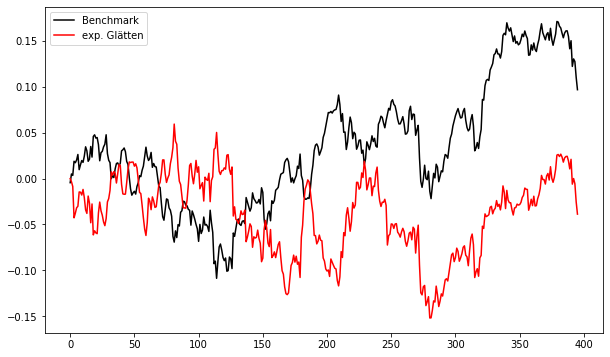

In [41]:
# Renditeverlauf des Gesamtportfolios

plt.figure(figsize=(10,6))
plt.plot(np.array(result_equal_vis).cumsum(),label='Benchmark', color = 'black')  
plt.plot(np.array(result_smooth_vis).cumsum(),label='exp. Glätten', color = 'red') 
plt.legend()
plt.show()



In [42]:
print('Portfolio' ,'Rendite','Volatilität','Sharpe-Ratio','alpha', 'beta' )
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('SMOOTHING', print_stats(result_smooth_vis, result_equal_vis))

Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
EQUAL [0.0002, 0.01, 0.4046, -0.0, 1.0]
SMOOTHING [-0.0001, 0.0125, -0.1238, -0.0, -0.3639]


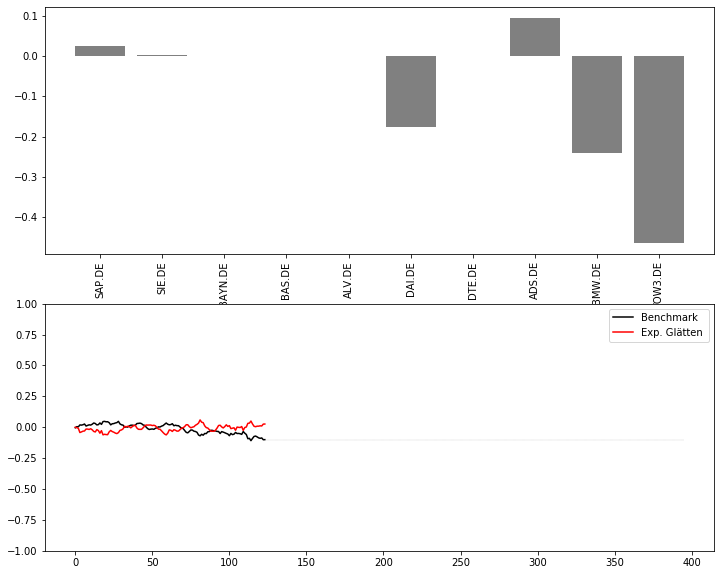

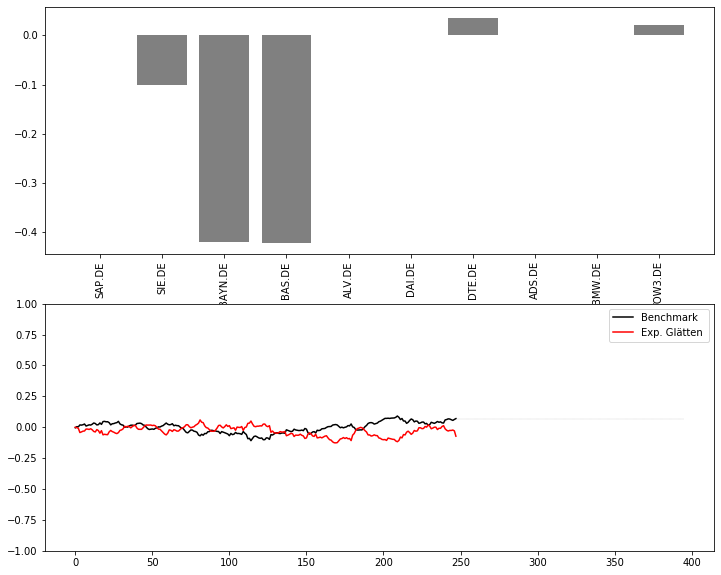

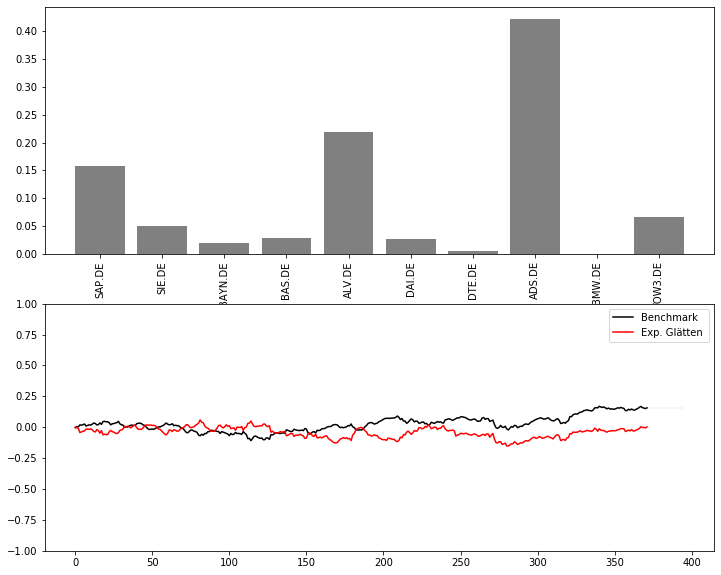

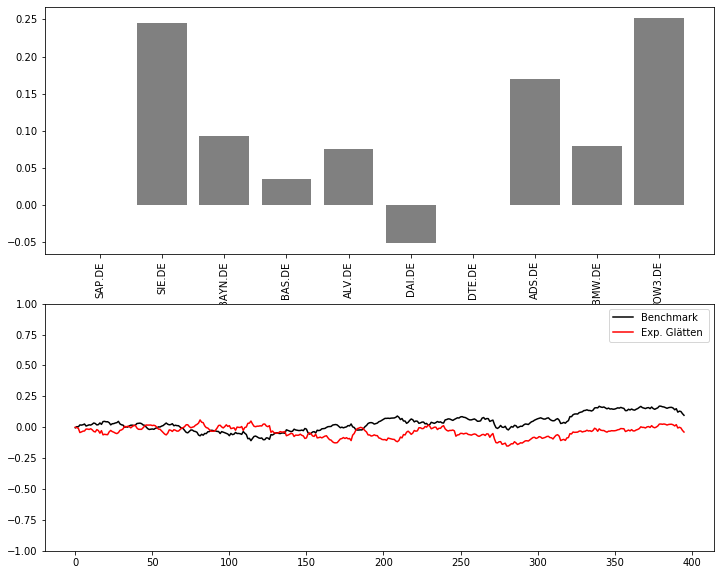

In [43]:
plot_results(result_equal, 
             result_smooth, 
             actions_smooth,
             N_ASSETS,
             state.columns, 
             'Exp. Glätten ', './images/smoothing/', 'series')

### GARCH-Modell


- GARCH: Verallgemeinerte autoregressiv bedingte Heteroskedastizitätsmodelle -   Generalized AutoRegressive Conditional Heteroskedasticitiy 
- Ziel: Bedingte Volatilität einer Zeitreihe zu modellieren
- Für Garch(1,1):   
   - $ r_t= \mu + \sigma_t \epsilon_t$  
   - $\sigma^{2}_{t} = \omega + \alpha \epsilon_{t-1} ^{2} + \beta \sigma_{t-1} ^{2}  $
   - $ \epsilon_t \sim WN(0,1)$ 
   - $\omega,\alpha, \beta >0$
   - $ \alpha + \beta < 1 $ für Stationarität
- $\alpha $ gibt den Einfluss von "Schocks" und $\beta $ die Dauer an
- Maximum Likelihood um die Parameter des GARCH-Modells an die beobachteten Daten anzupassen



In [24]:
from agent import GARCHAgent

In [25]:
agent_garch = GARCHAgent(N_ASSETS, allow_short=True, forecast_horizon = WINDOW_HOLD) # Prognosezeitraum = Haltedauer

In [26]:
actions_equal, actions_garch = [], []
result_equal, result_garch = [], []

for i in range(WINDOW_FIT, len(env.data), WINDOW_HOLD):
    # Trainingszeitraum
    state = env.get_state(i, WINDOW_FIT, is_cov_matrix=False, is_raw_time_series=True)# Daten für Trainingszeitraum 
    action_equal = np.ones(N_ASSETS) / N_ASSETS # Benchmark  der gleichgewichteten Aktien
    action_garch = agent_garch.act(state) # Gewichte der Aktien mittels exp. Glätten

    # Realisierung der Rendite der Methode 
    state_action = env.get_state(i+WINDOW_HOLD, WINDOW_HOLD, is_cov_matrix=False)
    
    r = np.dot(state_action, action_equal) # Portfoliorendite gleichgewichtetes Portfolio
    result_equal.append(r.tolist())
    actions_equal.append(action_equal)
    
    r = np.dot(state_action, action_garch) # Portfoliorendite - Prognose arc Glättung
    result_garch.append(r.tolist())
    actions_garch.append(action_garch)

In [27]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_garch_vis = [item for sublist in result_garch for item in sublist]



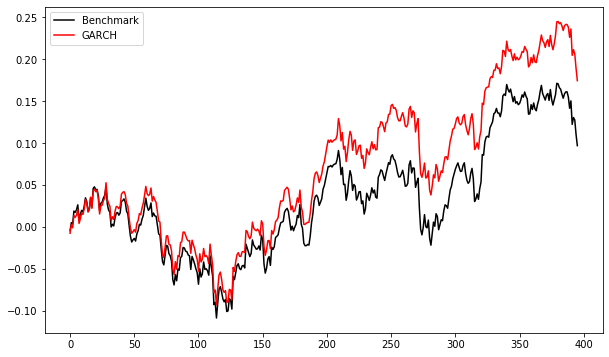

In [28]:
# Renditeverlauf des Gesamtportfolios

plt.figure(figsize=(10,6))
plt.plot(np.array(result_equal_vis).cumsum(),label='Benchmark', color = 'black')  
plt.plot(np.array(result_garch_vis).cumsum(),label='GARCH', color = 'red') 
plt.legend()
plt.show()



In [29]:
print('Portfolio' ,'Rendite','Volatilität','Sharpe-Ratio','alpha', 'beta' )
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('GARCH', print_stats(result_garch_vis, result_equal_vis))

Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
EQUAL [0.0002, 0.01, 0.4046, -0.0, 1.0]
GARCH [0.0004, 0.0103, 0.707, 0.0002, 1.0129]


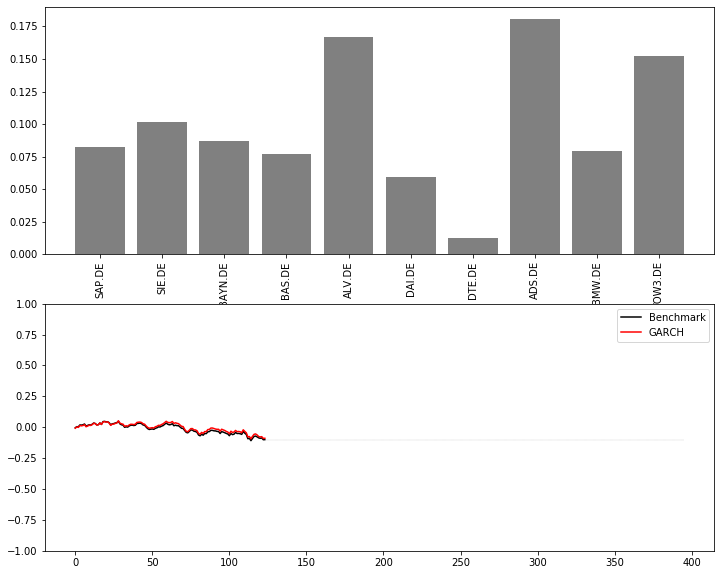

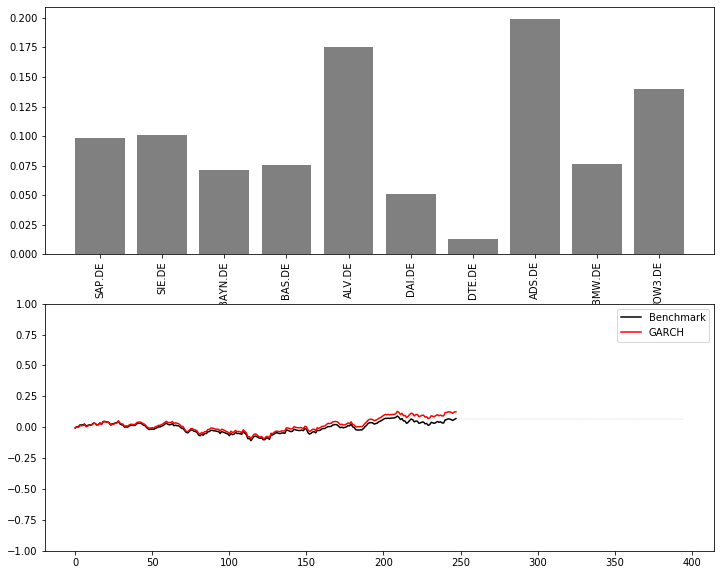

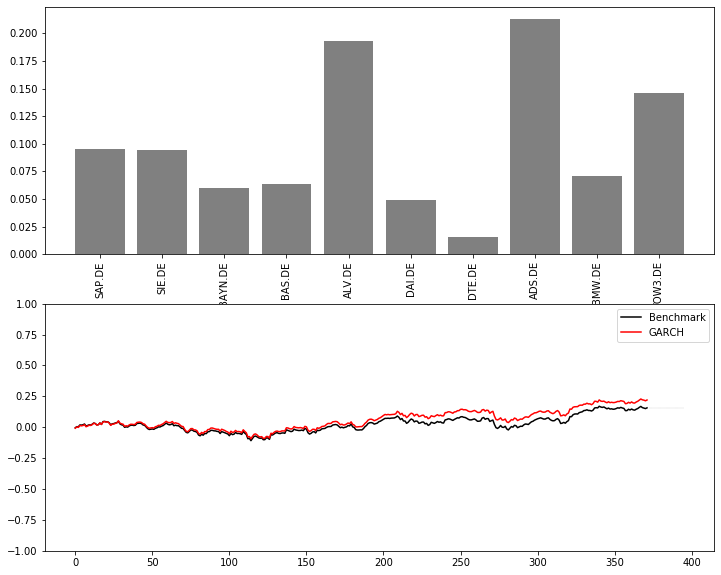

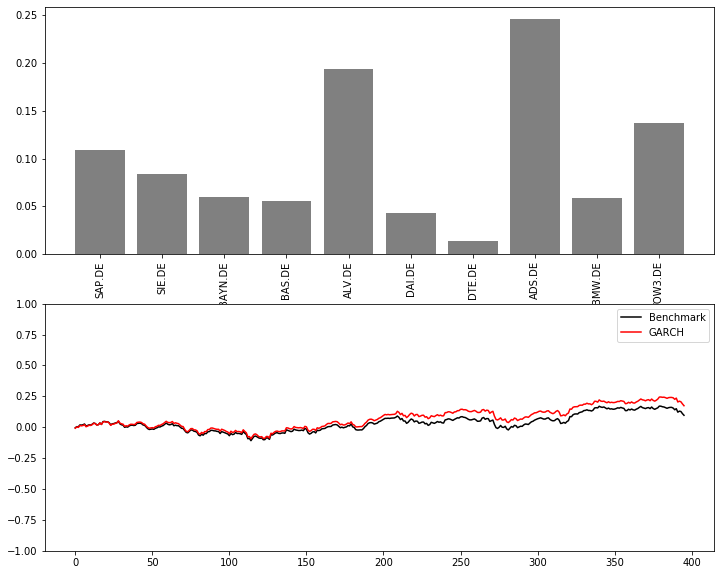

In [30]:
plot_results(result_equal, 
             result_garch, 
             actions_garch,
             N_ASSETS,
             state.columns, 
             'GARCH', './images/smoothing/', 'series')

# Fazit:



### Überblick über die Kennzahlen der einzelnen Methode


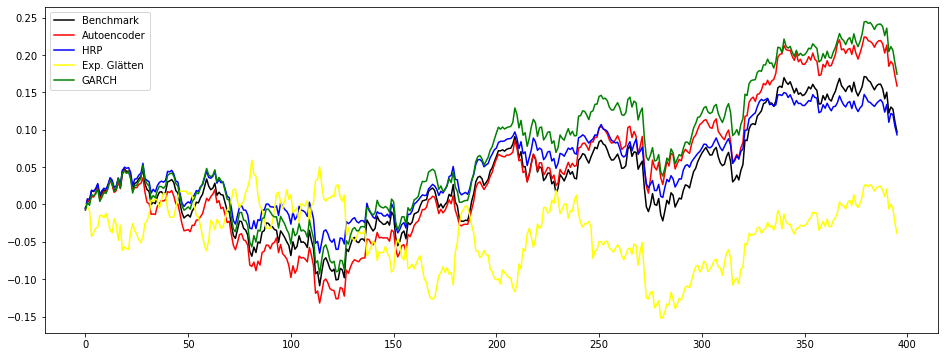

Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
EQUAL [0.0002, 0.01, 0.4046, -0.0, 1.0]
AUTOENCODER [0.0004, 0.0101, 0.6562, 0.0002, 0.9699]
HRP [0.0002, 0.0085, 0.4618, 0.0, 0.8266]
SMOOTHING [-0.0001, 0.0125, -0.1238, -0.0, -0.3639]
GARCH [0.0004, 0.0103, 0.707, 0.0002, 1.0129]


In [31]:
# Renditeverlauf des Gesamtportfolios 
plt.figure(figsize=(16,6))
plt.plot(np.array(result_equal_vis).cumsum(),color = 'black', label = 'Benchmark') 
plt.plot(np.array(result_ae_vis).cumsum(),color = 'red', label = 'Autoencoder')
plt.plot(np.array(result_hrp_vis).cumsum(),color = 'blue', label = 'HRP') 
plt.plot(np.array(result_smooth_vis).cumsum(),color = 'yellow', label = 'Exp. Glätten') 
plt.plot(np.array(result_garch_vis).cumsum(),label='GARCH', color = 'green') 
plt.legend()
plt.show()


print('Portfolio' ,'Rendite','Volatilität','Sharpe-Ratio','alpha', 'beta' )
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('AUTOENCODER', print_stats(result_ae_vis, result_equal_vis))
print('HRP', print_stats(result_hrp_vis, result_equal_vis))
print('SMOOTHING', print_stats(result_smooth_vis, result_equal_vis))
print('GARCH', print_stats(result_garch_vis, result_equal_vis))

#### Überblick 60 Tage Trainings-, sowie Haltedauer 
Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
- EQUAL [0.0002, 0.01, 0.35, -0.0, 1.0]
- AUTOENCODER [0.0004, 0.0106, 0.5441, 0.0001, 1.0286]
- HRP [0.0002, 0.0088, 0.4221, 0.0, 0.8501]
- SMOOTHING [-0.0005, 0.0099, -0.843, -0.0005, 0.0391]
- GARCH [0.0004, 0.0104, 0.5457, 0.0001, 1.0154]

<div>
<img src="Überblick_Methoden_60Tage.png" width="1200"/>
</div>



#### Überblick 20 Tage Trainings-, sowie Haltedauer 

Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
Portfolio Rendite Volatilität Sharpe-Ratio alpha beta
- EQUAL [0.0002, 0.01, 0.2492, -0.0, 1.0]
- AUTOENCODER [0.0004, 0.0104, 0.5459, 0.0002, 0.9973]
- HRP [0.0002, 0.0089, 0.2676, 0.0, 0.8495]
- SMOOTHING [-0.0001, 0.0088, -0.1244, -0.0, -0.1337]
- GARCH [0.0003, 0.0104, 0.4587, 0.0001, 1.0152]

<div>
<img src="Überblick_Methoden_20Tage.png" width="1200"/>
</div>


### Fazit:



- Betrachtung der Kennzahlen (Sharpe-Ratio) : GARCH-Modell und Autoencoder liefern das beste Ergebnis mit Bezug auf die Rendite unter entsprechendem Risiko
- Ausblick: Performance der Methoden mit weiteren Datensätzen bzw. Betrachtung der Daten über einen längeren Zeitraum 

- Kritisch zu bemerken: Die Gewichtung einzelner Aktien im Portfolio ist teilweise sehr hoch, dadurch kann ein konzentriertes Risiko entstehen
- Trainingszeitraum, Haltedauer und Prognosehorizont (exp. Glätten) besitzen einen Einfluss auf die Kennzahlen
- Autoencoder: Welche Dimensionsreduzierung ist sinnhaft, sodass der Prognosefehler minimal  und der Rechenaufwand überschaubar bleibt ?  - Backtesting mit verschiedenen Reduzierungen notwendig
- Schlechte Performance der Prognose mittels exponentieller Glättung : Zu simples Modell zur Prognose, die Vewendung des GARCH-Modells (stochastisches Volatilitätsmodell) liefert ein deutlich zu bevorzugendes Ergebnis

